---
# title: "My Notebook"
format:
  html:
    toc: true           # ✅ Table of contents (outline)
    toc-location: left  # ✅ Place TOC in the left sidebar
    number-sections: true
    code-fold: true
    code-summary: "Show Code"
    theme: cosmo        # Optional themes: cosmo, flatly, default, etc.
---

# Week 9B<br>Getting Data, Part 2: Working with APIs


**Week #7 Agenda**

**Last time**:

- Introduction to APIs
- Natural language processing via Philly's 311 API
    - Word frequencies

**Today:**

- Natural language processing via Philly's 311 API
    - Sentiment analysis
- Pulling census data and shape files via the Census API

In [1]:
# Data analysis
import geopandas as gpd
import numpy as np
import pandas as pd

# APIs
import requests

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
import holoviews as hv
import hvplot.pandas

In [2]:
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = None

## Part 1: Picking up where we left off

## Natural Language Processing and the 311 Request API

Today, we'll continue our analysis of 311 request descriptions queried through the API for the Philly 311 system, available at: [https://iframe.publicstuff.com/#?client_id=242](https://iframe.publicstuff.com/#?client_id=242)

We'll focus on *sentiment analysis* today.

Let's load the data from the 311 API first:

In [3]:
# Store the data we request
data = []

# Total number of pages
total_pages = 3

# Loop over each page
for page_num in range(1, total_pages + 1):
    # Print out the page number
    print(f"Getting data for page #{page_num}...")

    # Make the request
    r = requests.get(
        "https://vc0.publicstuff.com/api/2.0/requests_list",
        params={
            "client_id": 242,  # Unique identifier for Philadelphia
            "page": page_num,  # What page of data to pull
            "limit": 200,  # How many rows per page
        },
    )

    # Get the json
    d = r.json()

    # Add the new data to our list and save
    data = data + [r["request"] for r in d["response"]["requests"]]

# Create a dataframe
data = pd.DataFrame(data)

Getting data for page #1...
Getting data for page #2...
Getting data for page #3...


In [76]:
len(data)

600

In [4]:
data.head()

id  \
0  17210222   
1  17210217   
2  17210209   
3  17210205   
4  17210194   

                                                                        image_thumbnail  \
0                                                                                         
1                                                                                         
2  https://d17aqltn7cihbm.cloudfront.net/uploads/small_175b49b42c5a3679867210dff00fe177   
3  https://d17aqltn7cihbm.cloudfront.net/uploads/small_a25892486db59ac0728d350197c1f16b   
4  https://d17aqltn7cihbm.cloudfront.net/uploads/small_6bcc4e6f40a68fe0825b9e4322bac245   

                   title                                 description  \
0    Vacant Lot Clean Up                                   overgrown   
1                  Other                                               
2         Pothole Repair                             Whole in street   
3        Illegal Dumping                                   undefined   
4  Maintenance Complaint  Property is overgrown with grass and weeds   

      status                                          address  \
0  submitted       2222 Moore St, Philadelphia, PA 19145, USA   
1  submitted  10943 Waldemire Dr, Philadelphia, PA 19154, USA   
2  submitted            1223 Morris St,Philadelphia, PA 19148   
3  submitted        761 Sloan St, Philadelphia, PA 19104, USA   
4  submitted      7534 Tabor Ave, Philadelphia, PA 19111, USA   

                     location zipcode foreign_id  date_created  \
0                                None   17974478    1754566097   
1                                None   17974475    1754565873   
2  Philadelphia, Pennsylvania   19148   17974474    1754565680   
3                                None   17974473    1754565543   
4                                None   17974470    1754564609   

   count_comments  count_followers  count_supporters        lat        lon  \
0               0                0                 0  39.929688 -75.182719   
1               0                0                 0  40.076298 -74.982679   
2               0                0                 0  39.928913 -75.165887   
3               0                0                 0  39.966908 -75.202294   
4               0                0                 0  40.063343 -75.077113   

   user_follows  user_comments  user_request rank       user  \
0             0              0             0    1              
1             0              0             0    1              
2             0              0             0    1  spfdeutch   
3             0              0             0    1  unionhill   
4             0              0             0    1    mpa1213   

                                                                                                                                                                                                                                                                                                                                                                                                                                                               primary_attachment  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                             NaN  
1                                                                                                                                                                                                                                                                                                                                                                       

Let's remove rows with missing descriptions and get our list of descriptions:

In [5]:
# Remove rows with missing descriptions
data = data.dropna(subset=["description"])
data_final = data.loc[data["description"] != ""]

# Strip out spaces and convert to a list
descriptions = data_final["description"].str.strip().tolist()

And then run our steps to clean up our text data:

1. Break strings into words
1. Remove capitalization
1. Remove stop words
1. Remove punctuation

**1. Break strings into words**

Use the `.split()` command to break a string into words by splitting on spaces.

In [6]:
descriptions_words = [desc.split() for desc in descriptions]

This is a list of lists, e.g., the first element is a list of words. Let's *flatten* this into a list of just words:

In [7]:
descriptions_words_flat = []

for list_of_words in descriptions_words:
    for word in list_of_words:
        descriptions_words_flat.append(word)

**2. Convert all words to lower case**

Use `.lower()` makes all words lower cased

In [8]:
descriptions_words_lower = [word.lower() for word in descriptions_words_flat]

**3. Remove stop words**

Common words that do not carry much significance and are often ignored in text analysis.

In [9]:
import nltk

nltk.download("stopwords");

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jianglix/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Get the list of common stop words:

In [10]:
stop_words = list(set(nltk.corpus.stopwords.words("english")))

stop_words[:10]

['the',
 'from',
 'for',
 'into',
 'in',
 'mightn',
 've',
 'these',
 'while',
 "wouldn't"]

In [11]:
descriptions_no_stop = []

for word in descriptions_words_lower:
    if word not in stop_words:
        descriptions_no_stop.append(word)

In [12]:
len(descriptions_no_stop)

14301

**4. Remove punctuation**

Get the list of common punctuation:

In [13]:
import string

In [14]:
punctuation = list(string.punctuation)

In [15]:
punctuation[:5]

['!', '"', '#', '$', '%']

Remove punctuation from words:

In [16]:
descriptions_final = []

# Loop over all words
for word in descriptions_no_stop:
    
    # Remove any punctuation from the words
    for p in punctuation:
        word = word.replace(p, "")
        
    # Save it if the string is not empty
    if word != "":
        descriptions_final.append(word)

Convert to a Dataframe with one column:

In [17]:
words = pd.DataFrame({"words": descriptions_final})

In [18]:
words.head()

words
0  overgrown
1      whole
2     street
3  undefined
4   property

### Use case #1: calculating word frequencies

An example of **text mining**

Use a pandas groupby and sort to put in descending order:

In [19]:
N = words.groupby("words", as_index=False).size().sort_values("size", ascending=False, ignore_index=True)

The top 15 words by frequency:

In [20]:
top15 = N.head(15)

top15

words  size
0         street   234
1          trash   220
2         please   215
3         people   190
4     especially   175
5   philadelphia   174
6         police   140
7           17th   140
8           3815   140
9         eagles   121
10         north   109
11        arrest   105
12           gay   104
13       contact   104
14       address    97

**Plot the frequencies**

Use `seaborn` to plot our DataFrame of word counts...

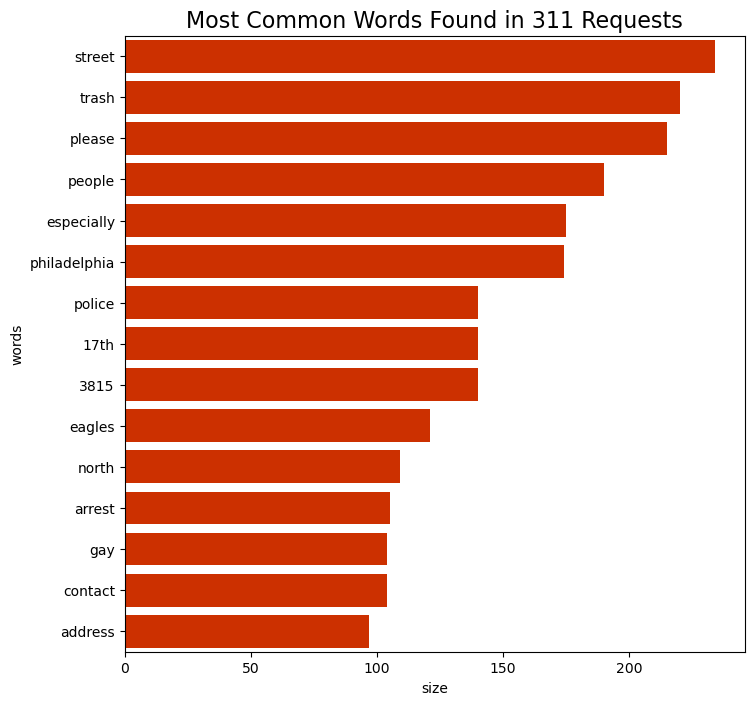

In [21]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
sns.barplot(
    y="words",
    x="size",
    data=top15,
    ax=ax,
    color="#cc3000",
    saturation=1.0,
)

ax.set_title("Most Common Words Found in 311 Requests", fontsize=16);

**Takeaway:** Philly cares about trash! They don't call it Filthadelphia for nothing...

Now, let's visualize with a **word cloud**

Use the [wordcloud](https://amueller.github.io/word_cloud/) package to make a simple word cloud of the word frequencies. 

::: {.callout-note}

We'll need to pass a single string to the WordCloud function. We can combine a list of strings by using the join function and specifying the join separator to be a space (" ")

```python
> strings = ["this", "is", "an", "example"]

> combined_string = " ".join(strings)

> combined_string
'this is an example'
```

:::

In [25]:
# !pip install wordcloud

In [26]:
from wordcloud import WordCloud

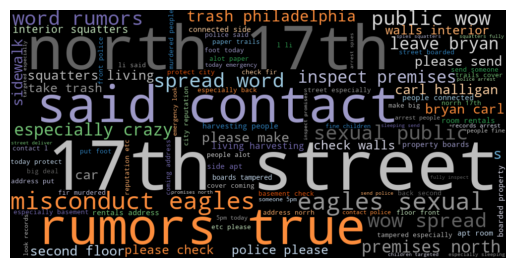

In [27]:
# Create a word cloud object
wc = WordCloud(
    background_color="black", max_words=100, width=1000, height=500, colormap="tab20c"
)

# NEW: Create a single string from all of our descriptions
text = " ".join(descriptions_final)

# Generate the image
img = wc.generate(text)

# The matplotlib fig/ax
fig, ax = plt.subplots()

# Show the image
ax.imshow(img, interpolation="bilinear")

# Format
ax.set_axis_off()
plt.show();

### Use case #2: sentiment analysis

The goal of a **sentiment analysis** is to determine the attitude or emotional state of the person who wrote a piece of text. It is often used by brands to evaluate public opinion about a product. 

**The goal**

Determine the "sentiment" of every word in the English language

*The hard way*

Train a machine learning algorithm to classify words as positive vs. negative, given an input training sample of words.

*The easy way*

Luckily, this is a **very common** task in NLP and there are several packages available that have done the hard work for you. 

They provide out-of-the-box sentiment analysis using pre-trained machine learning algorithms.

#### The `textblob` package

First, let's try out a package called `textblob`. Textblob can calculate the "polarity" of words, from negative -1 to postive +1. 

It's algorithm is not particularly sophisticated (as we will see). It was trained on IMDB movie reviews and uses a dictionary mapping of adjectives to sentiment values. So, it knows about a set of adjectives and an approximate *polarity* for those words. 

Let's try it out on the words from the 311 requests

In [30]:
# !pip install textblob

In [31]:
import textblob

First, copy our "words" dataframe and drop any duplicate words. We'll try to calculate the sentiment for each word.

In [32]:
sentiment = words.copy().drop_duplicates(subset=['words'])

In [33]:
sentiment.head()

words
0  overgrown
1      whole
2     street
3  undefined
4   property

Now, create our "text blob" objects:

In [34]:
blobs = [textblob.TextBlob(word) for word in sentiment['words']]

Now use the ".polarity" attribute to calculate the sentiment:

In [35]:
sentiment["polarity"] = [blob.polarity for blob in blobs]

In [36]:
sentiment.head(10)

words  polarity
0   overgrown       0.0
1       whole       0.2
2      street       0.0
3   undefined       0.0
4    property       0.0
6       grass       0.0
7       weeds       0.0
8      parked       0.0
9      months       0.0
10  obviously       0.0

Most of these words are zero!

In [37]:
(sentiment['polarity'] == 0).sum()

np.int64(1885)

In [38]:
len(sentiment)

2068

Why did this happen?

Because the universe of words that TextBlob knows about is pretty small! Mostly confined to common adjectives/adverbs that appeared in its IMDB review dataset.

Let's take a look at the words with nonzero polarity:

In [39]:
sentiment_nonzero = sentiment.query("polarity != 0")

What are the top 15 most positive words?

In [40]:
sentiment_nonzero.sort_values("polarity", ascending=False, ignore_index=True).head(15)

words  polarity
0      awesome       1.0
1         best       1.0
2   incredibly       0.9
3      greatly       0.8
4        brave       0.8
5        great       0.8
6          fly       0.8
7         good       0.7
8          apt       0.6
9          own       0.6
10      kindly       0.6
11   hazardous       0.6
12        nice       0.6
13      safely       0.5
14         top       0.5

What are the top 15 most negative words?

In [41]:
sentiment_nonzero.sort_values("polarity", ascending=True, ignore_index=True).head(15)

words  polarity
0     terrible -1.000000
1     horrible -1.000000
2   disgusting -1.000000
3        nasty -1.000000
4       insane -1.000000
5        awful -1.000000
6    sickening -0.900000
7         sick -0.714286
8         ugly -0.700000
9        badly -0.700000
10         bad -0.700000
11  impossible -0.666667
12   dangerous -0.600000
13  deplorable -0.600000
14      stinks -0.600000

What about a histogram of the sentiment?

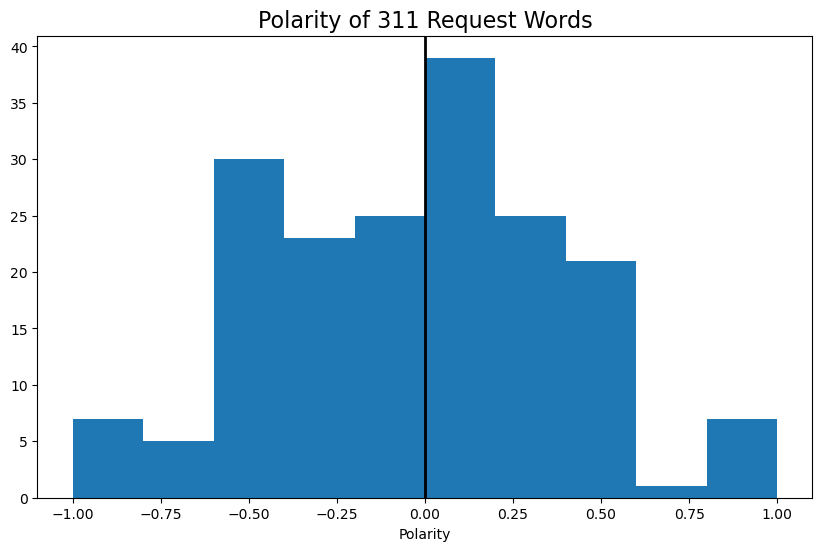

In [42]:
# create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# histogram
ax.hist(sentiment_nonzero["polarity"], bins="auto")
ax.axvline(x=0, c="k", lw=2)

# format
ax.set_xlabel("Polarity")
ax.set_title("Polarity of 311 Request Words", fontsize=16);

Hmm...this is surprising! There are many more positive words than I would have guessed!

**What could be going on?**


Most of the 311 requests are in fact *very* negative. They are mostly complaints, after all.

In the previous analysis, TextBlob only knows the sentiment for a *small* subset of the words. This is makes it difficult to produce a comprehensive sentiment for the entirety of the text for each 311 request. This is difficult because context really matters! Let's see an example:

As you can see in the below example, the negation is not picked up by the algorithm: 

In [43]:
textblob.TextBlob("Philly 311 is the best").polarity

1.0

In [44]:
textblob.TextBlob("Philly 311 is NOT the best").polarity

1.0

Both are marked as positive! (because of the word "best")

Can we do better? YES!

#### The `transformers` package

The Hugging Face `transformers` package ([documentation](https://huggingface.co/docs/transformers/index)) provides access to state-of-the-art, pre-trained machine learning algorithms for natural language processing. 

It provides access to more sophisticated machine learning models that are capable of measuring the sentiment of a piece of text using the full context of the words.



We can use the transformers `pipeline()` function to load and run our pre-trained models

In [49]:
# !pip install transformers
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 MB 1.2 MB/s eta 0:00:0000:0100:02


In [53]:
from transformers import pipeline
import torch

#### Positive/Negative sentiment analysis

We'll start with a version of the [DistilBERT](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) model that has been fine-tuned on the [Stanford Sentiment Treebank](https://huggingface.co/datasets/sst2) dataset.

For an input series of text, this model will predict the POSITIVE / NEGATIVE labels with associated confidence scores. It will tell us how likely it thinks the text is positive or negative.

::: {.callout-tip}
For more info on sentiment analysis with the `transformers` package, check out this [tutorial](https://huggingface.co/docs/transformers/tasks/sequence_classification).
:::

In [55]:
import torch  # <--- Required to avoid NameError
from transformers import pipeline

model = "distilbert-base-uncased-finetuned-sst-2-english"

sentiment_classifier = pipeline(
    task="sentiment-analysis",
    model=model,
    tokenizer=model,
    top_k=None,
    truncation=True
)

result = sentiment_classifier("I love using AI for urban planning!")
print(result)

NameError: name 'torch' is not defined

Now, let's pass our original list of request descriptions to the classifier. 

::: {.callout-note}
We don't need to do any text pre-processing here! We'll just pass in the raw text, so no need to remove stop words, punctuation, etc.
:::


We're now running a much more sophisticated model, so it will take more time to execute! This will likely take 2-3 minutes to run...

In [56]:
%%time

scores = sentiment_classifier(descriptions)

NameError: name 'sentiment_classifier' is not defined

What does the response structure look like?

For each description, we get a dictionary containing the label (`POSITIVE` or `NEGATIVE`) and the associated score:

In [114]:
scores[:10]

[[{'label': 'POSITIVE', 'score': 0.9495417475700378},
  {'label': 'NEGATIVE', 'score': 0.050458285957574844}],
 [{'label': 'POSITIVE', 'score': 0.508097231388092},
  {'label': 'NEGATIVE', 'score': 0.49190279841423035}],
 [{'label': 'NEGATIVE', 'score': 0.6410784721374512},
  {'label': 'POSITIVE', 'score': 0.35892152786254883}],
 [{'label': 'NEGATIVE', 'score': 0.9990324974060059},
  {'label': 'POSITIVE', 'score': 0.000967523199506104}],
 [{'label': 'NEGATIVE', 'score': 0.9988860487937927},
  {'label': 'POSITIVE', 'score': 0.0011139643611386418}],
 [{'label': 'NEGATIVE', 'score': 0.9983736276626587},
  {'label': 'POSITIVE', 'score': 0.001626323675736785}],
 [{'label': 'NEGATIVE', 'score': 0.8497042059898376},
  {'label': 'POSITIVE', 'score': 0.15029579401016235}],
 [{'label': 'NEGATIVE', 'score': 0.8308085799217224},
  {'label': 'POSITIVE', 'score': 0.1691913902759552}],
 [{'label': 'POSITIVE', 'score': 0.9935035109519958},
  {'label': 'NEGATIVE', 'score': 0.006496530957520008}],
 [{'la

Let's unpack this to a more useful format:

In [116]:
yes_no = pd.DataFrame([{d["label"]: d["score"] for d in dd} for dd in scores]).assign(
    text=descriptions
)

In [117]:
yes_no.head()

POSITIVE  NEGATIVE  \
0  0.949542  0.050458   
1  0.508097  0.491903   
2  0.358922  0.641078   
3  0.000968  0.999032   
4  0.001114  0.998886   

                                                                                                                                                                               text  
0                                                                                                On the southwest corner of the intersection of S. 46th Street and Woodland Avenue.  
1                                                   On the 'No Dumping' street sign on the south side of Cedar Avenue about 11 steps west of S. 46th Street. Next to the tiny park.  
2                                                     Apartment complex is dumping trash on our street again! Please help or tell me the proper channels I need to take. Thank you!  
3                                                     People speed up the street like they’re all 95 it needs to have street cushions put in or speed bumps whatever you wanna call  
4  This vehicle has been parked on the 5300 block of Sycamore Street. The car appears to be stolen and parts from the vehicle were removed such as Steering wheel – and other items

**Note:** The scores summed across both labels will sum up to 1. 


**Total sentiment calculation**:
We can calculate the overall score by multiplying the value for each label, e.g., (POSITIVE = +1 and NEGATIVE = -1) by the confidence score for each label. This gives an overall sentiment estimate for each piece of text:

In [118]:
yes_no["sentiment"] = (yes_no["POSITIVE"] * +1) + (yes_no["NEGATIVE"] * -1)

In [119]:
yes_no.head()

POSITIVE  NEGATIVE  \
0  0.949542  0.050458   
1  0.508097  0.491903   
2  0.358922  0.641078   
3  0.000968  0.999032   
4  0.001114  0.998886   

                                                                                                                                                                               text  \
0                                                                                                On the southwest corner of the intersection of S. 46th Street and Woodland Avenue.   
1                                                   On the 'No Dumping' street sign on the south side of Cedar Avenue about 11 steps west of S. 46th Street. Next to the tiny park.   
2                                                     Apartment complex is dumping trash on our street again! Please help or tell me the proper channels I need to take. Thank you!   
3                                                     People speed up the street like they’re all 95 it needs to have street cushions put in or speed bumps whatever you wanna call   
4  This vehicle has been parked on the 5300 block of Sycamore Street. The car appears to be stolen and parts from the vehicle were removed such as Steering wheel – and other items   

   sentiment  
0   0.899083  
1   0.016194  
2  -0.282157  
3  -0.998065  
4  -0.997772

**Question:** Are most of the reviews positive or negative?


Let's take a look at the mean and median:

In [120]:
yes_no['sentiment'].mean()

-0.708985571766335

In [121]:
yes_no['sentiment'].median()

-0.9924230165779591

Ah! By far, most of these are negative!

Philadelphians using the 311 system appear to be *very* upset.

Let's take a look at the overall histogram of sentiment too:

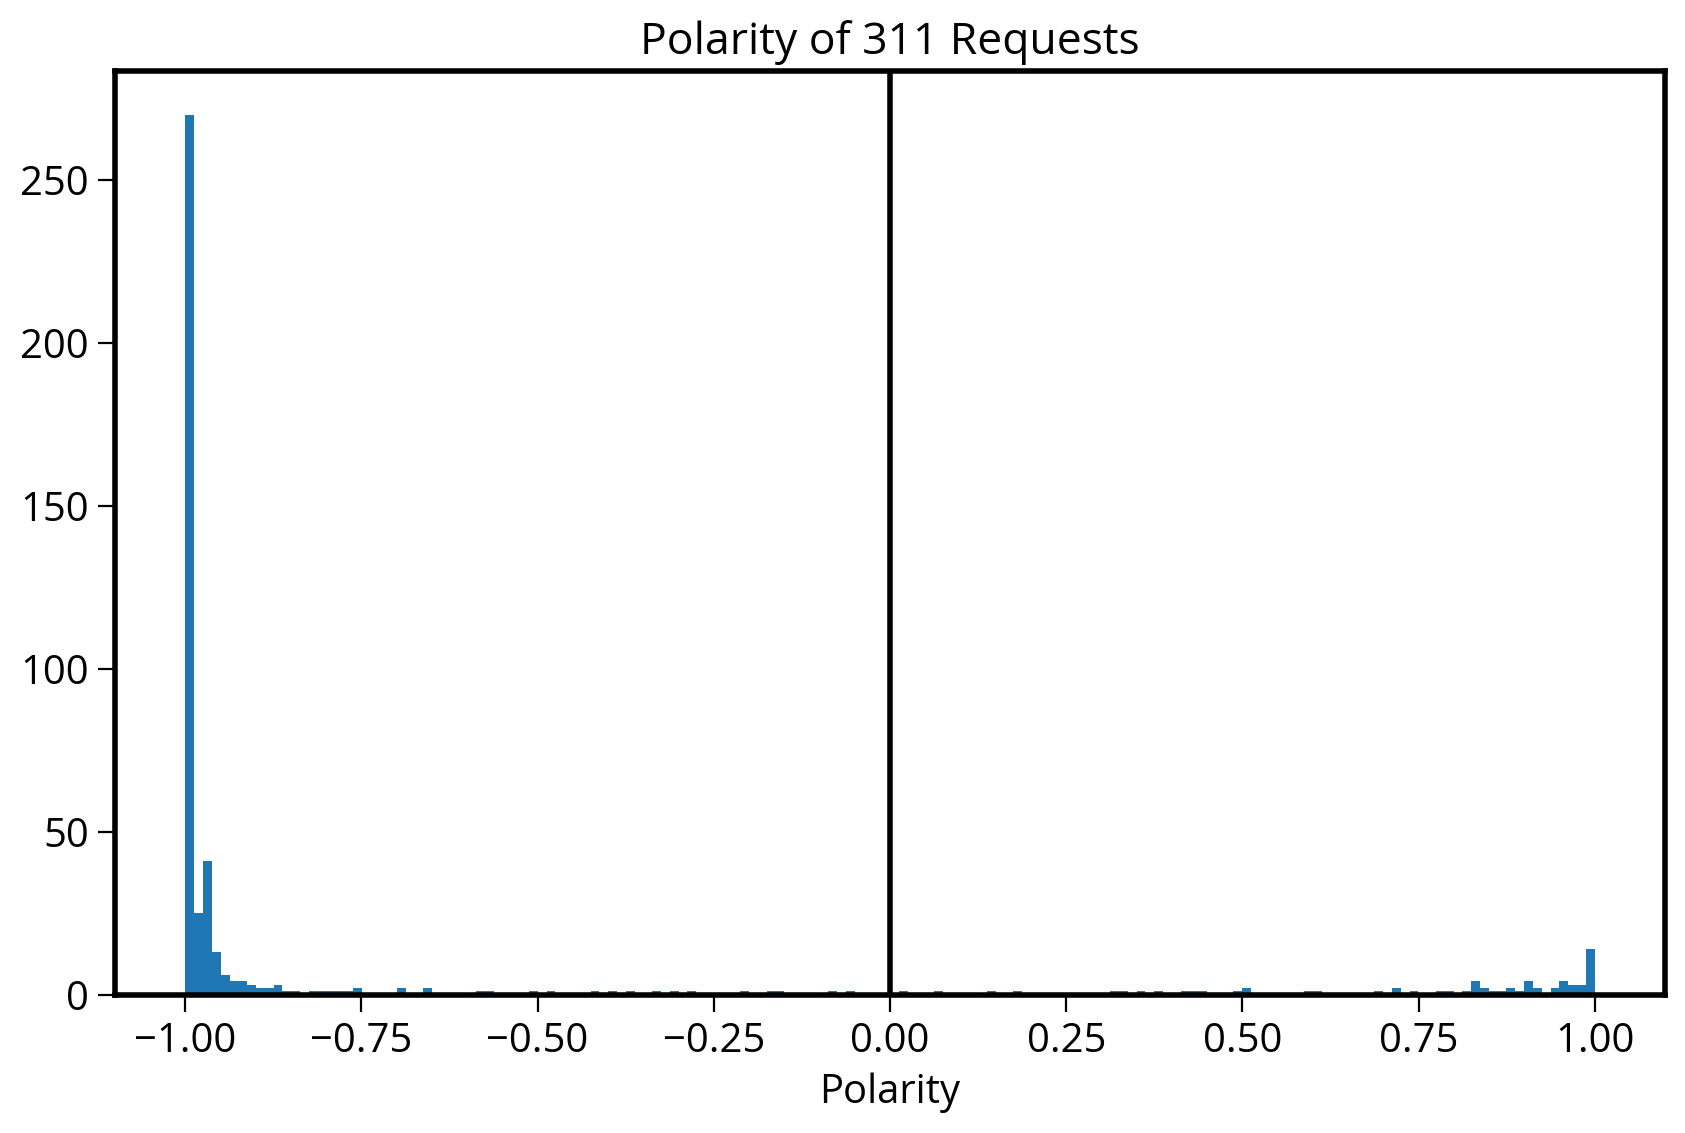

In [128]:
# Create a figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Histogram
ax.hist(yes_no['sentiment'], bins="auto")
ax.axvline(x=0, c="k", lw=2)

# Format
ax.set_xlabel("Polarity")
ax.set_title("Polarity of 311 Requests", fontsize=16);

Whoa! Very negative sentiment!

**This makes much more sense than our earlier results with the Textblob package.**

Let's look at the 10 requests with the lowest sentiment scores:

In [129]:
yes_no.sort_values("sentiment", ascending=True).head(10)

POSITIVE  NEGATIVE  \
388  0.000206  0.999794   
89   0.000217  0.999783   
74   0.000240  0.999760   
153  0.000252  0.999748   
399  0.000255  0.999745   
46   0.000256  0.999744   
81   0.000264  0.999736   
227  0.000268  0.999731   
130  0.000270  0.999730   
49   0.000272  0.999728   

                                                                                                                                                                                    text  \
388                                                                                                                                                   Expired tags and appears abandoned   
89                                                                                                                         Sewer is letting out really bad smell and is full of garbage.   
74                                                                                                                                                                     sidewalk collapse   
153                             The park lights that go on when it is dark out have been out non-functioning for over a month now. It is incredibly dark in the evening and is not safe.   
399                                                                                        The 2nd floor of the 1155 S 9th Street moved out and they dumped their stuff on the sidewalk.   
46                         Dangerous trash items dumped in the funeral home parking lot that was never removed properly from the past construction site at 625 Byberry Rd phila PA 19116   
81   The trash on this block is unreal. No one bags anything up, so it blows all over. It's bad every day of the week, not just trash day. This block needs to be given real trash cans.   
227      These chairs have been sitting here for months, on City (PHA) Property. They say "Mummers Museum" on them, but they're just rusting and looking like trash in our neighborhood.   
130                                                                                        Dumped boat alongside the 6400 Cottage St along Roosevelt Playground. It is filled with trash   
49                                                                                                  Trash has been on sidewalk for nearly a month. City Trash truck will not pick it up.   

     sentiment  
388  -0.999587  
89   -0.999565  
74   -0.999520  
153  -0.999496  
399  -0.999489  
46   -0.999489  
81   -0.999471  
227  -0.999463  
130  -0.999460  
49   -0.999455

And the 10 requests with the highest sentiment:

In [130]:
yes_no.sort_values("sentiment", ascending=False).head(10)

POSITIVE  NEGATIVE  \
314  0.999784  0.000216   
323  0.999711  0.000289   
324  0.999711  0.000289   
154  0.999605  0.000395   
33   0.999430  0.000570   
223  0.998891  0.001109   
129  0.998437  0.001563   
212  0.998410  0.001590   
348  0.998193  0.001807   
51   0.997944  0.002056   

                                                                                                                                                                                                                                                                                                                          text  \
314                                                                                                                                                                                                                                                                        Graffiti and sticker on sign. Please and thank you!   
323                                                                                                                                                                                                                                                                                    Graffiti on sign. Please and thank you!   
324                                                                                                                                                                                                                                                                                    Graffiti on sign. Please and thank you!   
154                                                                                                                                                                                                                                                               Graffiti on entire side of building on 1850 Hope. Thank you!   
33                                                                                                                                                                                                                                                             People speed up this street and we have children on this street   
223  The Calder Gardens construction site has a bright light on all night every night that shines across the entire neighborhood. I understand they need to light up the construction area but surely it doesn’t need to shine upwards into all of our bedrooms at night? It’s much brighter than any other light in the area.   
129                                                                                                                                                                                                                                                                                               Overflowing into my property   
212                                                                                                                                                                                                                                                                                                   center of Cianfrani Park   
348                                                                                                                                                                                           Everyone trash was picked up except mine, and my trash was at curbside on time. I live at the corner house it’s not hard to miss   
51                                                                                                                                                                                                                                                            hey there is still an encampment here. growing bigger every day.   

     sentiment  
314   0.999567  
323   0.999422  
324   0.999422  
154   0.999210  
33    0.998860  
223   0.997782  
129   0.996873  
212   0.996820  
348   0.996

**Takeaway**

The model is still clearly focusing on some crucial words (please, thank you = "positive") but overall, doing a much, much better job overall of understanding the full context of the text. 

#### Emotion sentiment analysis

The `transformers` package also includes pre-trained models that can predict *emotion* labels. 

As an example, let's try out [this version](https://huggingface.co/bhadresh-savani/distilbert-base-uncased-emotion) of the DistilBERT model that can predict the following labels for a string of text: anger, fear, sadness, joy, love, and surprise.

In [131]:
# The model
model = "bhadresh-savani/distilbert-base-uncased-emotion"

# Initialize our sentiment analyzer
emotion_classifier = pipeline(
    task="text-classification",  # The task we are doing
    model=model,  # The specific model name
    top_k=None,  # Predict all labels, not just top ones
    tokenizer=model,  # Tokenize inputs using model tokenizer
    truncation=True,  # Truncate text if we need to
)

Classify the 311 descriptions using our emotions model. Once again, this will likely take 2-3 minutes to run:

In [132]:
%%time 

emotion_scores = emotion_classifier(descriptions)

CPU times: user 23min 21s, sys: 8.8 s, total: 23min 30s
Wall time: 2min 48s


In [133]:
emotion_scores[0]

[{'label': 'fear', 'score': 0.6695271134376526},
 {'label': 'anger', 'score': 0.19726096093654633},
 {'label': 'joy', 'score': 0.09402022510766983},
 {'label': 'sadness', 'score': 0.01936410740017891},
 {'label': 'surprise', 'score': 0.012043606489896774},
 {'label': 'love', 'score': 0.0077839684672653675}]

Unpack the label/score combos into a DataFrame:

In [134]:
emotion = pd.DataFrame(
    [{d["label"]: d["score"] for d in dd} for dd in emotion_scores]
).assign(text=descriptions)

In [135]:
emotion.head()

fear     anger       joy   sadness  surprise      love  \
0  0.669527  0.197261  0.094020  0.019364  0.012044  0.007784   
1  0.859705  0.120488  0.010728  0.003260  0.004663  0.001155   
2  0.000414  0.002554  0.989055  0.001997  0.000243  0.005738   
3  0.184317  0.698201  0.062046  0.050890  0.002694  0.001853   
4  0.740593  0.133473  0.011053  0.108852  0.004859  0.001170   

                                                                                                                                                                               text  
0                                                                                                On the southwest corner of the intersection of S. 46th Street and Woodland Avenue.  
1                                                   On the 'No Dumping' street sign on the south side of Cedar Avenue about 11 steps west of S. 46th Street. Next to the tiny park.  
2                                                     Apartment complex is dumping trash on our street again! Please help or tell me the proper channels I need to take. Thank you!  
3                                                     People speed up the street like they’re all 95 it needs to have street cushions put in or speed bumps whatever you wanna call  
4  This vehicle has been parked on the 5300 block of Sycamore Street. The car appears to be stolen and parts from the vehicle were removed such as Steering wheel – and other items

Now, let's calculate the predicted label for each text. This is the label with the highest score for each text.

In [136]:
emotion_labels = ["anger", "fear", "sadness", "joy", "surprise", "love"]

Use the `idxmax()` function to find the column with the maximum value for each row:

In [137]:
emotion[emotion_labels].idxmax(axis=1)

0       fear
1       fear
2        joy
3      anger
4       fear
       ...  
462    anger
463    anger
464    anger
465     fear
466     fear
Length: 467, dtype: object

In [138]:
emotion['prediction'] = emotion[emotion_labels].idxmax(axis=1)

In [139]:
emotion.head()

fear     anger       joy   sadness  surprise      love  \
0  0.669527  0.197261  0.094020  0.019364  0.012044  0.007784   
1  0.859705  0.120488  0.010728  0.003260  0.004663  0.001155   
2  0.000414  0.002554  0.989055  0.001997  0.000243  0.005738   
3  0.184317  0.698201  0.062046  0.050890  0.002694  0.001853   
4  0.740593  0.133473  0.011053  0.108852  0.004859  0.001170   

                                                                                                                                                                               text  \
0                                                                                                On the southwest corner of the intersection of S. 46th Street and Woodland Avenue.   
1                                                   On the 'No Dumping' street sign on the south side of Cedar Avenue about 11 steps west of S. 46th Street. Next to the tiny park.   
2                                                     Apartment complex is dumping trash on our street again! Please help or tell me the proper channels I need to take. Thank you!   
3                                                     People speed up the street like they’re all 95 it needs to have street cushions put in or speed bumps whatever you wanna call   
4  This vehicle has been parked on the 5300 block of Sycamore Street. The car appears to be stolen and parts from the vehicle were removed such as Steering wheel – and other items   

  prediction  
0       fear  
1       fear  
2        joy  
3      anger  
4       fear

What's the breakdown across the predicted labels?

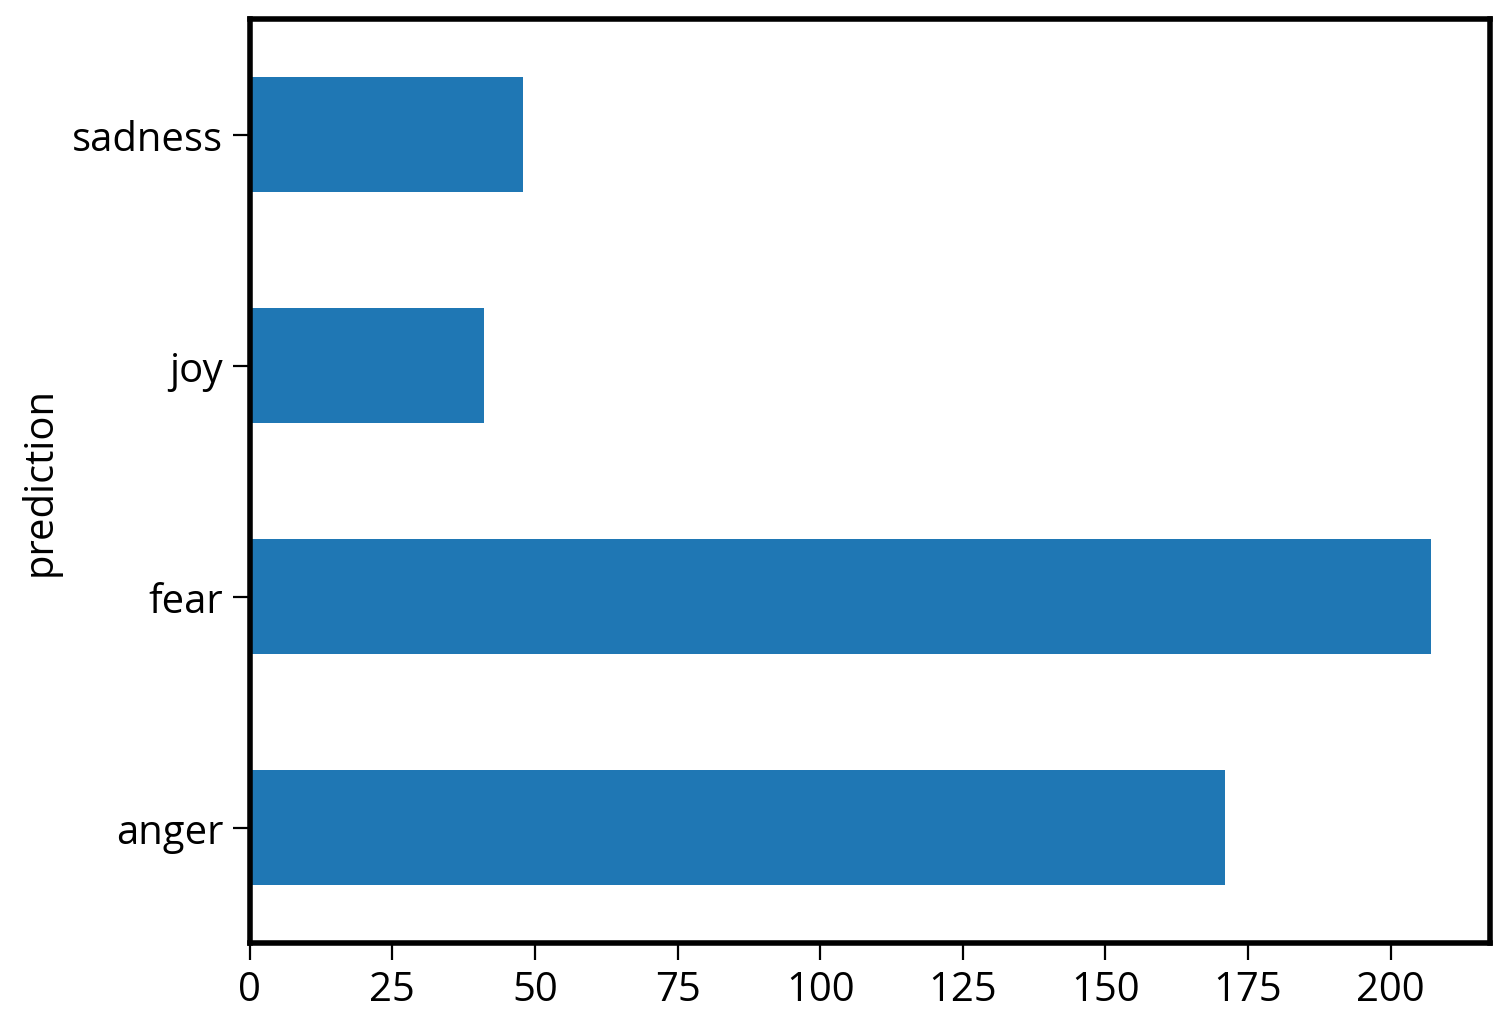

In [140]:
emotion.groupby("prediction").size().plot(kind='barh');

**Takeaway:**  Most descriptions are classified as "fear" or "anger"

How about visualizing the full distribution of scores across all emotions?

Let's get a tidy version for analysis:

In [141]:
emotion_tidy = emotion.melt(
    id_vars=["text"], value_vars=emotion_labels, var_name="emotion", value_name="score"
)

In [142]:
emotion_tidy.head()

text  \
0                                                                                                On the southwest corner of the intersection of S. 46th Street and Woodland Avenue.   
1                                                   On the 'No Dumping' street sign on the south side of Cedar Avenue about 11 steps west of S. 46th Street. Next to the tiny park.   
2                                                     Apartment complex is dumping trash on our street again! Please help or tell me the proper channels I need to take. Thank you!   
3                                                     People speed up the street like they’re all 95 it needs to have street cushions put in or speed bumps whatever you wanna call   
4  This vehicle has been parked on the 5300 block of Sycamore Street. The car appears to be stolen and parts from the vehicle were removed such as Steering wheel – and other items   

  emotion     score  
0   anger  0.197261  
1   anger  0.120488  
2   anger  0.002554  
3   anger  0.698201  
4   anger  0.133473

Make a box plot of the distribution across all emotions:

/Users/nhand/mambaforge/envs/musa-550-fall-2023/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


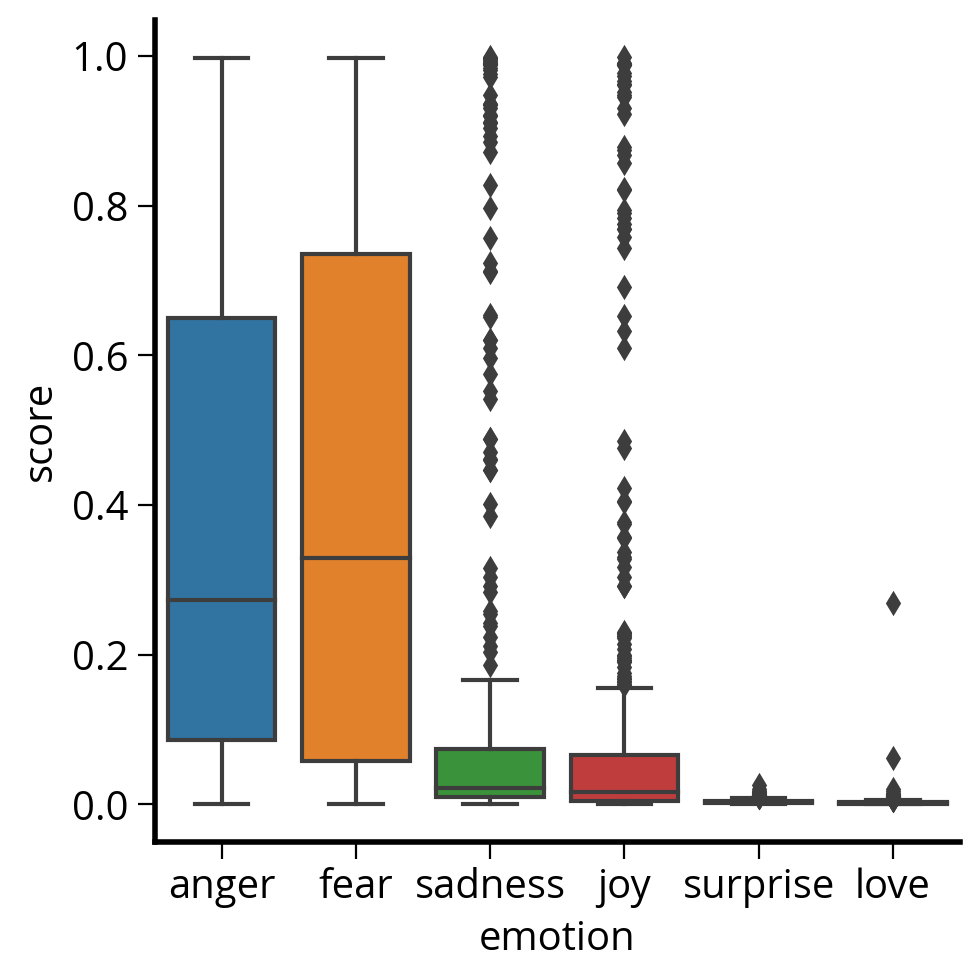

In [143]:
sns.catplot(data=emotion_tidy, x="emotion", y="score", kind="box");

**Takeaway:**

Fear and anger! For emotions other than anger/fear, confidence scores are concentrated near zero, indicating that the text likely does not contain those emotions.

Let's do a deeper dive on some of the emotions:

**Anger**

In [144]:
angry_requests = emotion.query("anger > 0.8").sort_values("anger", ascending=False)

In [145]:
len(angry_requests)

80

In [146]:
angry_requests.head(20)

fear     anger       joy   sadness  surprise      love  \
246  0.001147  0.997735  0.000239  0.000609  0.000134  0.000136   
160  0.000773  0.996903  0.000356  0.001579  0.000128  0.000261   
132  0.001949  0.996713  0.000410  0.000497  0.000167  0.000264   
53   0.003206  0.995312  0.000421  0.000688  0.000160  0.000212   
312  0.002940  0.995312  0.000595  0.000742  0.000163  0.000248   
255  0.003880  0.994278  0.000740  0.000621  0.000198  0.000283   
64   0.004393  0.993969  0.000550  0.000664  0.000175  0.000248   
61   0.004737  0.993821  0.000505  0.000447  0.000204  0.000286   
409  0.007373  0.990195  0.000709  0.001310  0.000198  0.000215   
46   0.009776  0.987523  0.000854  0.001446  0.000197  0.000205   
256  0.010180  0.986226  0.001814  0.001106  0.000227  0.000447   
156  0.006585  0.985632  0.000858  0.006336  0.000319  0.000270   
189  0.009659  0.979324  0.003577  0.006531  0.000243  0.000665   
459  0.002977  0.977072  0.001047  0.018333  0.000232  0.000340   
42   0.015931  0.976699  0.002130  0.004426  0.000417  0.000396   
417  0.024150  0.971062  0.001833  0.002366  0.000305  0.000285   
352  0.015262  0.968072  0.005341  0.010229  0.000613  0.000484   
213  0.025253  0.966334  0.004253  0.003255  0.000459  0.000447   
293  0.016661  0.961744  0.002837  0.017831  0.000588  0.000340   
272  0.012939  0.960171  0.009602  0.015907  0.000799  0.000582   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       text  \
246                                                                                                                                                                                                                                                                                                                                                                             The are rocks and other debris items that have been picked out of the trash blocking the entry and exit way to the driveway. The owner also puts some type of white chemicals on it and it has caused damage to my vehicle numerous times.  There are dirty trash bags hanging along the fence area. If a resident ask her to move it she becomes very irate and combative.   
160                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     Hate speech  on side of building on 13th and spruce   
132                                                                                                                                                                                                                                                                                                                                                                                                         

**Fear**

And the most fearful:

In [147]:
fearful_requests = emotion.query("fear > 0.8").sort_values("fear", ascending=False)

In [148]:
len(fearful_requests)

76

In [149]:
fearful_requests.head(20)

fear     anger       joy   sadness  surprise      love  \
38   0.997108  0.000887  0.000408  0.000987  0.000443  0.000168   
261  0.992042  0.004499  0.000603  0.002248  0.000411  0.000196   
203  0.991208  0.002228  0.000442  0.000383  0.005459  0.000279   
277  0.990393  0.004574  0.000967  0.003393  0.000470  0.000203   
110  0.988391  0.003221  0.001139  0.005514  0.001511  0.000224   
163  0.984954  0.007672  0.000770  0.005747  0.000573  0.000284   
340  0.982761  0.004817  0.001064  0.008939  0.002184  0.000234   
72   0.981407  0.010381  0.001214  0.005825  0.000919  0.000253   
320  0.968219  0.008872  0.001683  0.019192  0.001595  0.000439   
230  0.966225  0.024689  0.004373  0.003271  0.001061  0.000381   
292  0.965217  0.017342  0.005371  0.010168  0.001536  0.000367   
361  0.964056  0.014632  0.002278  0.016545  0.002014  0.000475   
434  0.961617  0.024714  0.001440  0.010248  0.001597  0.000384   
201  0.955390  0.038087  0.002316  0.002883  0.000855  0.000470   
414  0.953619  0.030410  0.001820  0.012103  0.001673  0.000377   
35   0.953109  0.020269  0.001983  0.022810  0.001401  0.000428   
171  0.951624  0.026008  0.012353  0.006975  0.002333  0.000708   
140  0.950077  0.022618  0.002368  0.023805  0.000685  0.000447   
97   0.948384  0.044143  0.001950  0.004101  0.001067  0.000355   
69   0.945735  0.039572  0.002658  0.010071  0.001614  0.000350   

                                                                                                                                                                                                                                                                                                                                                                                                                                                           text  \
38                                         I reside next door to this vacant property. The entire back of the house is falling down. There are several squirrels, possums and raccoons hanging out of the house. There is debris falling into my backyard and my children are afraid to play back there. There are now magets falling through my sons room because I believe there is something dead in his walls. Please contact me at 267-904-1753, thank you   
261                                                                                                                  Open flames are being lit underneath 95 every night, which is a major fire hazard. Area has become an illegal dumping site filled with mounds of trash. Unsafe conditions with discarded needles, human waste, tents, shopping carts. Residents are afraid to walk by due to unsanitary conditions and aggressive nature of camp dwellers.   
203                                                                                                                                                                                                                                                                                                                                      The cave-in is getting larger as time goes by.  When trucks or buses go by, our whole house shakes, it is frightening.   
277                                                                                                                                                                                                                                        2840 N Judson St porch is danger of collapse, held up by a board.  ppl in the home dumping construction trash on the corner. Neighbors homes next door is in danger when the porch collapse too.  couldn't load pic.   
110                                                                                                                                                                                                                                                                                                                                                       

**Takeaway:**

Overall, the algorithm is doing a pretty good job picking up the emotion and sentiment in the requests. 

One potential use case for a model like this: *prioritizing responses*. For example:

- You might want to respond more quickly to those that are classified as the most fearful, given that those situations might be the most dangerous. 
- Or, requests that are classified as the angriest might warrant a closer follow-up from a city representative, since many of these requests are likely repeated requests from frustrated residents.

But, once again, we see the limitations of sentiment analysis as text with words like "thank you" and "please" get classified as positive ("joy"):

In [150]:
joyful_requests = emotion.query("joy > 0.8").sort_values("joy", ascending=False)

Not that many requests!

In [151]:
len(joyful_requests)

24

In [152]:
joyful_requests.head(20)

fear     anger       joy   sadness  surprise      love  \
218  0.000202  0.000358  0.998168  0.000476  0.000334  0.000462   
314  0.000329  0.001318  0.990678  0.000946  0.000373  0.006355   
154  0.000567  0.002886  0.989135  0.002578  0.000688  0.004146   
2    0.000414  0.002554  0.989055  0.001997  0.000243  0.005738   
323  0.000729  0.003696  0.988631  0.001794  0.000529  0.004622   
324  0.000729  0.003696  0.988631  0.001794  0.000529  0.004622   
456  0.000768  0.004943  0.988528  0.004332  0.000329  0.001101   
460  0.000843  0.005435  0.987868  0.004306  0.000416  0.001132   
397  0.000218  0.000780  0.976723  0.000954  0.000370  0.020955   
223  0.006227  0.015431  0.973137  0.003297  0.001020  0.000887   
437  0.000971  0.014033  0.965937  0.003748  0.000639  0.014671   
319  0.001974  0.027491  0.962027  0.006175  0.000655  0.001678   
29   0.008942  0.015654  0.960725  0.003665  0.010158  0.000856   
426  0.005569  0.010426  0.951224  0.015387  0.016442  0.000953   
366  0.038893  0.005748  0.947229  0.005978  0.001100  0.001052   
135  0.002884  0.045254  0.945802  0.003459  0.001008  0.001593   
170  0.007085  0.049680  0.929838  0.005769  0.001051  0.006578   
153  0.052773  0.011042  0.922465  0.011364  0.001248  0.001109   
431  0.016508  0.077170  0.878651  0.014538  0.001941  0.011193   
430  0.020282  0.084760  0.873991  0.016648  0.001504  0.002814   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  text  \
218                                                                                                                                                                                                                                                vehicle hasnt ran well over a year inspection sticker in front appears to have been alter it read  11/2020 now you only see the 11 this vehicle is just taking up some valuable spot for another car that runs SO MANY VIOLATION IN THE 15TH DISTRICT THAT JUST GETTING THEY ARE SO MANY CARS IN AREA THAT ARE NOT RUNNING THEY ARE IILEGAL taking up so many spots   
314                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                Graffiti and sticker on sign. Please and thank you!   
154                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Graffiti on entire side of building on 1850 Hope. Thank you!   
2                                                                                                                                                                                                

*Sentiment analysis* -- a helpful, but imperfect analysis tool!

## Part 2: The Census API

### US Census data is foundational

- Rich data sets with annual releases
- Decennial results plus American Community Survey (ACS) results
- Wide range of topics covered: sex, income, poverty, education, housing

### Getting census data (the new way)<br>census.data.gov

<center>
    <a href=https://data.census.gov/><img src="imgs/census-2.png" width=700></img></a>
</center>

### Example: poverty data
<center>
    <a href="https://data.census.gov/table/ACSST1Y2021.S1701?q=poverty+status&g=010XX00US$0400000&tid=ACSST1Y2021.S1701"><img src="imgs/poverty-1.png" width=900></img></a>
</center>

#### Via the API

[https://api.census.gov/data/2021/acs/acs1?get=NAME,B17001_002E&for=state:*](https://api.census.gov/data/2021/acs/acs1?get=NAME,B17001_002E&for=state:*)

- **Base endpoint:** https://api.census.gov/data/2021/acs/acs1
- **Request parameters:** "get", "for"

![](imgs/poverty-2.png)

### How to find the right variable names?

The census provides web-based documentation:

- Overview of all data tables: [https://api.census.gov/data.html](https://api.census.gov/data.html)
- All data tables for 2021: [https://api.census.gov/data/2021.html](https://api.census.gov/data/2021.html)
- All variables for 2021 ACS 5-year data set: [https://api.census.gov/data/2021/acs/acs5/variables.html](https://api.census.gov/data/2021/acs/acs5/variables.html)

### A detailed Census API guide

[https://www.census.gov/data/developers/guidance/api-user-guide.html](https://www.census.gov/data/developers/guidance/api-user-guide.html)

### Accessing the API is easier from Python

Several packages provide easier Python interfaces to census data based on the census API.

We'll focus on **`cenpy` - "Explore and download data from Census APIs"**
 - [Documentation](https://cenpy-devs.github.io/cenpy/)
 - [GitHub](https://github.com/cenpy-devs/cenpy)

### Example: the racial "dot" map

![](imgs/racial-dot-map.png)

Source: [Washington Post](https://www.washingtonpost.com/graphics/2018/national/segregation-us-cities/)

Let's make this for Philadelphia in Python!

In [4]:
# !pip install cenpy

In [24]:
# First step: import cenpy
import cenpy

#### The "explorer" module

Functions to help you explore the Census API from Python

- [`cenpy.explorer.available`](https://cenpy-devs.github.io/cenpy/generated/cenpy.explorer.available.html#cenpy.explorer.available): Returns information about available datasets in Census API
- [`cenpy.explorer.explain`](https://cenpy-devs.github.io/cenpy/generated/cenpy.explorer.explain.html#cenpy.explorer.explain): Explain a specific Census dataset
- [`cenpy.explorer.fips_table`](https://cenpy-devs.github.io/cenpy/generated/cenpy.explorer.fips_table.html#cenpy.explorer.fips_table): Get a table of FIPS codes for a specific geography

**Note: we can change pandas display options to see all rows/columns and large cells**

In [6]:
# UNCOMMENT TO SEE ALL ROWS/COLUMNS IN DATAFRAMES
# pd.options.display.max_rows = 9999 
# pd.options.display.max_colwidth = 200

#### Step 1: Identify what dataset we want

- Today, we'll use the 5-year American Community Survey (latest available year: 2021)
- Other common datasets: 
    - 1-year ACS datasets as well (latest available year: 2022)
    - 10-year decennial survey (latest available year: 2020)

In [25]:
import cenpy
available = cenpy.explorer.available()

available.head()

/opt/anaconda3/envs/geospatial/lib/python3.10/site-packages/cenpy/explorer.py:70: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  listcols = raw_table.applymap(lambda x: isinstance(x, list)).any()


c_isTimeseries c_isMicrodata           publisher   temporal  \
ABSCB2017            NaN           NaN  U.S. Census Bureau  2017/2017   
ABSCB2018            NaN           NaN  U.S. Census Bureau  2018/2018   
ABSCB2019            NaN           NaN  U.S. Census Bureau  2019/2019   
ABSCB2020            NaN           NaN  U.S. Census Bureau  2020/2020   
ABSCB2021            NaN           NaN  U.S. Census Bureau  2021/2021   

                 spatial programCode               modified    keyword  \
ABSCB2017  United States     006:007  2020-04-30 00:00:00.0  (census,)   
ABSCB2018  United States     006:007  2020-10-26 00:00:00.0  (census,)   
ABSCB2019             US     006:007  2021-08-17 00:00:00.0  (census,)   
ABSCB2020             US     006:007  2022-08-03 00:00:00.0  (census,)   
ABSCB2021  United States     006:007  2023-07-24 10:30:52.0  (census,)   

                                                contactPoint  \
ABSCB2017  {'fn': 'ABS Staff', 'hasEmail': 'mailto:adep.a...   
ABSCB2018  {'fn': 'ABS Staff', 'hasEmail': 'mailto:adep.a...   
ABSCB2019  {'fn': 'ASE Staff', 'hasEmail': 'mailto:ERD.an...   
ABSCB2020  {'fn': 'ASE Staff', 'hasEmail': 'mailto:ERD.an...   
ABSCB2021  {'fn': 'ABS Staff', 'hasEmail': 'mailto:adep.a...   

                                                distribution  \
ABSCB2017  {'@type': 'dcat:Distribution', 'accessURL': 'h...   
ABSCB2018  {'@type': 'dcat:Distribution', 'accessURL': 'h...   
ABSCB2019  {'@type': 'dcat:Distribution', 'accessURL': 'h...   
ABSCB2020  {'@type': 'dcat:Distribution', 'accessURL': 'h...   
ABSCB2021  {'@type': 'dcat:Distribution', 'accessURL': 'h...   

                                                 description bureauCode  \
ABSCB2017  The Annual Business Survey (ABS) provides info...     006:07   
ABSCB2018  The Annual Business Survey (ABS) provides info...     006:07   
ABSCB2019  The Annual Business Survey (ABS) provides info...     006:07   
ABSCB2020  The Annual Business Survey (ABS) provides info...     006:07   
ABSCB2021  The Annual Business Survey (ABS) provides info...     006:07   

          accessLevel                                              title  \
ABSCB2017      public  Annual Business Survey: Characteristics of Bus...   
ABSCB2018      public  Annual Business Survey: Characteristics of Bus...   
ABSCB2019      public  2019 Annual Business Survey: Characteristics o...   
ABSCB2020      public  2020 Annual Business Survey: Characteristics o...   
ABSCB2021      public  2021 Annual Business Survey: Characteristics o...   

           c_isAvailable c_isCube c_isAggregate c_dataset  vintage  
ABSCB2017           True      NaN          True  (abscb,)   2017.0  
ABSCB2018           True      NaN          True  (abscb,)   2018.0  
ABSCB2019           True      NaN          True  (abscb,)   2019.0  
ABSCB2020           True      NaN          True  (abscb,)   2020.0  
ABSCB2021           True      NaN          True  (abscb,)   2021.0

We can use the pandas [`filter()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.filter.html) to search for specific identifiers in the dataframe. 

In this case, let's search for the American Community Survey datasets. We'll match index labels using *regular expressions*. 

In particular, we'll search for labels that start with "ACS". In the language of regular expressions, we'll use the "^" to mean "match labels that start with"

For more info on regular expressions, the [documentation for the re module](https://docs.python.org/3/library/re.html) is a good place to start.

In [26]:
# Return a dataframe of all datasets that start with "ACS"
# Axis=0 means to filter the index labels!
acs = available.filter(regex="^ACS", axis=0)

acs

c_isTimeseries c_isMicrodata           publisher   temporal  \
ACSCD1132011            NaN           NaN  U.S. Census Bureau  2011/2011   
ACSCD1152015            NaN           NaN  U.S. Census Bureau  2015/2015   
ACSCP1Y2010             NaN           NaN  U.S. Census Bureau        NaN   
ACSCP1Y2011             NaN           NaN  U.S. Census Bureau        NaN   
ACSCP1Y2012             NaN           NaN  U.S. Census Bureau        NaN   
...                     ...           ...                 ...        ...   
ACSST5Y2019             NaN           NaN  U.S. Census Bureau        NaN   
ACSST5Y2020             NaN           NaN  U.S. Census Bureau  2020/2020   
ACSST5Y2021             NaN           NaN  U.S. Census Bureau  2021/2021   
ACSST5Y2022             NaN           NaN  U.S. Census Bureau  2022/2022   
ACSST5Y2023             NaN           NaN  U.S. Census Bureau  2023/2023   

                    spatial programCode               modified    keyword  \
ACSCD1132011  United States     006:004             2014-10-06  (census,)   
ACSCD1152015  United States     006:004             2017-02-10  (census,)   
ACSCP1Y2010   United States     006:004  2018-09-18 00:00:00.0  (census,)   
ACSCP1Y2011   United States     006:004  2018-09-18 00:00:00.0  (census,)   
ACSCP1Y2012             NaN     006:004  2018-07-05 00:00:00.0  (census,)   
...                     ...         ...                    ...        ...   
ACSST5Y2019             NaN     006:004  2020-04-03 00:00:00.0  (census,)   
ACSST5Y2020              US     006:004  2021-07-13 00:00:00.0  (census,)   
ACSST5Y2021              US     006:004  2022-08-08 00:00:00.0  (census,)   
ACSST5Y2022              US     006:004  2023-09-05 12:01:35.0  (census,)   
ACSST5Y2023              US     006:004  2024-09-06 17:27:43.0  (census,)   

                                                   contactPoint  \
ACSCD1132011  {'fn': 'American Community Survey Office', 'ha...   
ACSCD1152015  {'fn': 'American Community Survey Office', 'ha...   
ACSCP1Y2010   {'fn': 'American Community Survey Office', 'ha...   
ACSCP1Y2011   {'fn': 'American Community Survey Office', 'ha...   
ACSCP1Y2012   {'fn': 'American Community Survey Office', 'ha...   
...                                                         ...   
ACSST5Y2019   {'fn': 'American Community Survey Office', 'ha...   
ACSST5Y2020   {'fn': 'American Community Survey Office', 'ha...   
ACSST5Y2021   {'fn': 'American Community Survey Office', 'ha...   
ACSST5Y2022   {'fn': 'American Community Survey Office', 'ha...   
ACSST5Y2023   {'fn': 'American Community Survey Office', 'ha...   

                                                   distribution  \
ACSCD1132011  {'@type': 'dcat:Distribution', 'accessURL': 'h...   
ACSCD1152015  {'@type': 'dcat:Distribution', 'accessURL': 'h...   
ACSCP1Y2010   {'@type': 'dcat:Distribution', 'accessURL': 'h...   
ACSCP1Y2011   {'@type': 'dcat:Distribution', 'accessURL': 'h...   
ACSCP1Y2012   {'@type': 'dcat:Distribution', 'accessURL': 'h...   
...                                                         ...   
ACSST5Y2019   {'@type': 'dcat:Distribution', 'accessURL': 'h...   
ACSST5Y2020   {'@type': 'dcat:Distribution', 'accessURL': 'h...   
ACSST5Y2021   {'@type': 'dcat:Distribution', 'accessURL': 'h...   
ACSST5Y2022   {'@type': 'dcat:Distribution', 'accessURL': 'h...   
ACSST5Y2023   {'@type': 'dcat:Distribution', 'accessURL': 'h...   

                                                    description bureauCode  \
ACSCD1132011  The American Community Survey (ACS) is a natio...     006:07   
ACSCD1152015  The American Community Survey (ACS) is an ongo...     006:07   
ACSCP1Y2010   The American Community Survey (ACS) is an ongo...     006:07   
ACSCP1Y2011   The American Community Survey (ACS) is an ongo...     006:07   
ACSCP1Y2012   The American Community Survey (ACS) is an ongo...     006:07   
...                                                         ...        ...   
ACSST5Y2019   The A

Many flavors of ACS datasets are available — we want to use the *detailed tables* version, specifically the 5-year survey. 

The relevant identifiers start with: "ACSDT5Y".

In [27]:
# Return a dataframe of all datasets that start with "ACSDT5Y"
available.filter(regex="^ACSDT5Y", axis=0)

c_isTimeseries c_isMicrodata           publisher   temporal  \
ACSDT5Y2009                NaN           NaN  U.S. Census Bureau        NaN   
ACSDT5Y2010                NaN           NaN  U.S. Census Bureau        NaN   
ACSDT5Y2011                NaN           NaN  U.S. Census Bureau        NaN   
ACSDT5Y2012                NaN           NaN  U.S. Census Bureau        NaN   
ACSDT5Y2013                NaN           NaN  U.S. Census Bureau        NaN   
ACSDT5Y2014                NaN           NaN  U.S. Census Bureau        NaN   
ACSDT5Y2015                NaN           NaN  U.S. Census Bureau        NaN   
ACSDT5Y2016                NaN           NaN  U.S. Census Bureau        NaN   
ACSDT5Y2017                NaN           NaN  U.S. Census Bureau        NaN   
ACSDT5Y2018                NaN           NaN  U.S. Census Bureau        NaN   
ACSDT5Y2019                NaN           NaN  U.S. Census Bureau        NaN   
ACSDT5Y2020                NaN           NaN  U.S. Census Bureau  2020/2020   
ACSDT5Y2021                NaN           NaN  U.S. Census Bureau  2021/2021   
ACSDT5Y2022                NaN           NaN  U.S. Census Bureau  2022/2022   
ACSDT5Y2023                NaN           NaN  U.S. Census Bureau  2023/2023   
ACSDT5YAIAN2010            NaN           NaN  U.S. Census Bureau        NaN   
ACSDT5YAIAN2015            NaN           NaN  U.S. Census Bureau        NaN   
ACSDT5YAIAN2021            NaN           NaN  U.S. Census Bureau  2021/2021   
ACSDT5YSPT2010             NaN           NaN  U.S. Census Bureau        NaN   
ACSDT5YSPT2015             NaN           NaN  U.S. Census Bureau        NaN   
ACSDT5YSPT2021             NaN           NaN  U.S. Census Bureau  2021/2021   

                       spatial programCode               modified    keyword  \
ACSDT5Y2009                NaN     006:004  2019-08-27 13:11:18.0  (census,)   
ACSDT5Y2010      United States     006:004  2018-07-04 00:00:00.0  (census,)   
ACSDT5Y2011                NaN     006:004  2018-07-04 00:00:00.0  (census,)   
ACSDT5Y2012                NaN     006:004  2018-07-04 00:00:00.0  (census,)   
ACSDT5Y2013                NaN     006:004  2018-07-04 00:00:00.0  (census,)   
ACSDT5Y2014                NaN     006:004  2018-07-04 00:00:00.0  (census,)   
ACSDT5Y2015                NaN     006:004  2018-07-05 00:00:00.0  (census,)   
ACSDT5Y2016                NaN     006:004  2018-07-05 00:00:00.0  (census,)   
ACSDT5Y2017                NaN     006:004  2018-08-21 07:11:43.0  (census,)   
ACSDT5Y2018                NaN     006:004  2019-10-22 16:28:02.0  (census,)   
ACSDT5Y2019                NaN     006:004  2020-04-03 00:00:00.0  (census,)   
ACSDT5Y2020                 US     006:004  2021-07-13 00:00:00.0  (census,)   
ACSDT5Y2021                 US     006:004  2022-08-08 00:00:00.0  (census,)   
ACSDT5Y2022                 US     006:004  2023-09-05 12:01:39.0  (census,)   
ACSDT5Y2023                 US     006:004  2024-09-06 17:27:47.0  (census,)   
ACSDT5YAIAN2010            NaN     006:004  2019-10-24 07:18:57.0  (census,)   
ACSDT5YAIAN2015            NaN     006:004  2020-02-13 00:00:00.0  (census,)   
ACSDT5YAIAN2021             US     006:004  2022-11-29 00:00:00.0  (census,)   
ACSDT5YSPT2010             NaN     006:004  2019-10-11 14:16:00.0  (census,)   
ACSDT5YSPT2015             NaN     006:004  2020-02-18 00:00:00.0  (census,)   
ACSDT5YSPT2021              US     006:004  2022-11-29 00:00:00.0  (census,)   

                                                      contactPoint  \
ACSDT5Y2009      {'fn': 'American Community Survey Office', 'ha...   
ACSDT5Y2010      {'fn': 'American Community Survey Office', 'ha...   
ACSDT5Y2011      {'fn': 'American Community Survey Office', 'ha...   
ACSDT5Y2012      {'fn': 'American Community Survey Office', 'ha...   
ACSDT5Y2013      {'fn': 'American Community Survey Office', 'ha...   
ACSDT5Y2014      {'fn': 'American Community Survey Office', 'ha...   
ACSDT5Y2015      {'fn': 'A

Let's use the latest available 5-year data (2021). We can use the `explain()` function to print out a description of the dataset:

In [28]:
import cenpy
cenpy.explorer.explain("ACSDT5Y2021")

{'American Community Survey: 5-Year Estimates: Detailed Tables 5-Year': 'The American Community Survey (ACS) is an ongoing survey that provides data every year -- giving communities the current information they need to plan investments and services. The ACS covers a broad range of topics about social, economic, demographic, and housing characteristics of the U.S. population. Summary files include the following geographies: nation, all states (including DC and Puerto Rico), all metropolitan areas, all congressional districts, all counties, all places, and all tracts and block groups. Summary files contain the most detailed cross-tabulations, many of which are published down to block groups. The data are population and housing counts. There are over 64,000 variables in this dataset.'}

#### Step 2: Initialize the API connection

Use the `cenpy.remote.APIConnection` object, and pass it the name of the dataset.

In [29]:
acs = cenpy.remote.APIConnection("ACSDT5Y2021")

#### Step 3: Find the variables we want to load

The `.variables` attribute stores the available variables (across all Census tables). 

We can use the `varslike()` function to search the `variables` dataframe (it's just a simple wrapper around the pandas `filter()` function).

In [30]:
len(acs.variables)

27927

In [31]:
acs.variables.head(n=5)

label  \
for                                Census API FIPS 'for' clause   
in                                  Census API FIPS 'in' clause   
ucgid                Uniform Census Geography Identifier clause   
B24022_060E   Estimate!!Total:!!Female:!!Service occupations...   
B19001B_014E             Estimate!!Total:!!$100,000 to $124,999   

                                                        concept predicateType  \
for                          Census API Geography Specification      fips-for   
in                           Census API Geography Specification       fips-in   
ucgid                        Census API Geography Specification         ucgid   
B24022_060E   SEX BY OCCUPATION AND MEDIAN EARNINGS IN THE P...           int   
B19001B_014E  HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 202...           int   

                group limit predicateOnly hasGeoCollectionSupport  \
for               N/A     0          True                     NaN   
in                N/A     0          True                     NaN   
ucgid             N/A     0          True                    True   
B24022_060E    B24022     0           NaN                     NaN   
B19001B_014E  B19001B     0           NaN                     NaN   

                                            attributes required  
for                                                NaN      NaN  
in                                                 NaN      NaN  
ucgid                                              NaN      NaN  
B24022_060E      B24022_060EA,B24022_060M,B24022_060MA      NaN  
B19001B_014E  B19001B_014EA,B19001B_014M,B19001B_014MA      NaN

We're interested in variables about hispanic origin broken down by race — let's see if we can find the variables where the "Concept" column starts with "RACE"

In [162]:
acs.varslike?

Signature: acs.varslike(pattern=None, by=None, engine='re', within=None)
Docstring:
Grabs columns that match a particular search pattern.

Parameters
----------
pattern : str
          a search pattern to match
by      : str
          a column in the APIConnection.variables to conduct the search
          within
engine  : {'re', 'fnmatch', callable}
          backend string matching module to use, or a function of the form
          match(candidate, pattern). (default: 're')
within  : pandas.DataFrame 
          the variables over which to search.

Notes
------
Only regex and fnmatch will be supported modules. Note that, while
regex is the default, the python regular expressions module has some
strange behavior if you're used to VIM or Perl-like regex. It may be
easier to use fnmatch if regex is not providing the results you expect.

If you want, you can also pass an engine that is a function. If so, this
needs to be a function that has a signature like:

fn(candidate, pattern)

and re

In [163]:
race_matches = acs.varslike(
    pattern="HISPANIC OR LATINO ORIGIN BY RACE",
    by="concept",  # searches along concept column
).sort_index()

In [164]:
race_matches

label  \
B03002_001E                                                                                                             Estimate!!Total:   
B03002_002E                                                                                    Estimate!!Total:!!Not Hispanic or Latino:   
B03002_003E                                                                       Estimate!!Total:!!Not Hispanic or Latino:!!White alone   
B03002_004E                                                   Estimate!!Total:!!Not Hispanic or Latino:!!Black or African American alone   
B03002_005E                                           Estimate!!Total:!!Not Hispanic or Latino:!!American Indian and Alaska Native alone   
B03002_006E                                                                       Estimate!!Total:!!Not Hispanic or Latino:!!Asian alone   
B03002_007E                                  Estimate!!Total:!!Not Hispanic or Latino:!!Native Hawaiian and Other Pacific Islander alone   
B03002_008E                                                             Estimate!!Total:!!Not Hispanic or Latino:!!Some other race alone   
B03002_009E                                                                Estimate!!Total:!!Not Hispanic or Latino:!!Two or more races:   
B03002_010E                           Estimate!!Total:!!Not Hispanic or Latino:!!Two or more races:!!Two races including Some other race   
B03002_011E  Estimate!!Total:!!Not Hispanic or Latino:!!Two or more races:!!Two races excluding Some other race, and three or more races   
B03002_012E                                                                                        Estimate!!Total:!!Hispanic or Latino:   
B03002_013E                                                                           Estimate!!Total:!!Hispanic or Latino:!!White alone   
B03002_014E                                                       Estimate!!Total:!!Hispanic or Latino:!!Black or African American alone   
B03002_015E                                               Estimate!!Total:!!Hispanic or Latino:!!American Indian and Alaska Native alone   
B03002_016E                                                                           Estimate!!Total:!!Hispanic or Latino:!!Asian alone   
B03002_017E                                      Estimate!!Total:!!Hispanic or Latino:!!Native Hawaiian and Other Pacific Islander alone   
B03002_018E                                                                 Estimate!!Total:!!Hispanic or Latino:!!Some other race alone   
B03002_019E                                                                    Estimate!!Total:!!Hispanic or Latino:!!Two or more races:   
B03002_020E                               Estimate!!Total:!!Hispanic or Latino:!!Two or more races:!!Two races including Some other race   
B03002_021E      Estimate!!Total:!!Hispanic or Latino:!!Two or more races:!!Two races excluding Some other race, and three or more races   
GEO_ID                                                                                                                         Geography   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

It looks like the table we want is "B03002" — we can also easily filter for all variables in this table

In [10]:
variables = [
    "NAME",
    "B03002_001E", # Total
    "B03002_003E", # Not Hispanic, White
    "B03002_004E", # Not Hispanic, Black
    "B03002_005E", # Not Hispanic, American Indian
    "B03002_006E", # Not Hispanic, Asian
    "B03002_007E", # Not Hispanic, Native Hawaiian
    "B03002_008E", # Not Hispanic, Other
    "B03002_009E", # Not Hispanic, Two or More Races
    "B03002_012E", # Hispanic
]

::: {.callout-note}
We've also include the "NAME" variable which returns the name of the Census geography we are querying for.
:::

#### Step 4: Identify the geographies to use

The Census API use heirarchy of geographies when requesting data.

For example, you cannot just request data for a specific county — you need to specify the state *and* the county.

<img src="imgs/census-hierarchy.png" width=700></img>

**Common hierarchies**

- State --> county
- State --> place (e.g., cities)
- State --> county --> tract
- State --> county --> tract --> block group

**Tip:** Use the `.geographies` attribute

This allows you to see:

1. What geographies are available for a specific dataset
1. The other required geographies in the heirarchy

In [13]:
acs

c_isTimeseries c_isMicrodata           publisher   temporal  \
ACSCD1132011            NaN           NaN  U.S. Census Bureau  2011/2011   
ACSCD1152015            NaN           NaN  U.S. Census Bureau  2015/2015   
ACSCP1Y2010             NaN           NaN  U.S. Census Bureau        NaN   
ACSCP1Y2011             NaN           NaN  U.S. Census Bureau        NaN   
ACSCP1Y2012             NaN           NaN  U.S. Census Bureau        NaN   
...                     ...           ...                 ...        ...   
ACSST5Y2019             NaN           NaN  U.S. Census Bureau        NaN   
ACSST5Y2020             NaN           NaN  U.S. Census Bureau  2020/2020   
ACSST5Y2021             NaN           NaN  U.S. Census Bureau  2021/2021   
ACSST5Y2022             NaN           NaN  U.S. Census Bureau  2022/2022   
ACSST5Y2023             NaN           NaN  U.S. Census Bureau  2023/2023   

                    spatial programCode               modified    keyword  \
ACSCD1132011  United States     006:004             2014-10-06  (census,)   
ACSCD1152015  United States     006:004             2017-02-10  (census,)   
ACSCP1Y2010   United States     006:004  2018-09-18 00:00:00.0  (census,)   
ACSCP1Y2011   United States     006:004  2018-09-18 00:00:00.0  (census,)   
ACSCP1Y2012             NaN     006:004  2018-07-05 00:00:00.0  (census,)   
...                     ...         ...                    ...        ...   
ACSST5Y2019             NaN     006:004  2020-04-03 00:00:00.0  (census,)   
ACSST5Y2020              US     006:004  2021-07-13 00:00:00.0  (census,)   
ACSST5Y2021              US     006:004  2022-08-08 00:00:00.0  (census,)   
ACSST5Y2022              US     006:004  2023-09-05 12:01:35.0  (census,)   
ACSST5Y2023              US     006:004  2024-09-06 17:27:43.0  (census,)   

                                                   contactPoint  \
ACSCD1132011  {'fn': 'American Community Survey Office', 'ha...   
ACSCD1152015  {'fn': 'American Community Survey Office', 'ha...   
ACSCP1Y2010   {'fn': 'American Community Survey Office', 'ha...   
ACSCP1Y2011   {'fn': 'American Community Survey Office', 'ha...   
ACSCP1Y2012   {'fn': 'American Community Survey Office', 'ha...   
...                                                         ...   
ACSST5Y2019   {'fn': 'American Community Survey Office', 'ha...   
ACSST5Y2020   {'fn': 'American Community Survey Office', 'ha...   
ACSST5Y2021   {'fn': 'American Community Survey Office', 'ha...   
ACSST5Y2022   {'fn': 'American Community Survey Office', 'ha...   
ACSST5Y2023   {'fn': 'American Community Survey Office', 'ha...   

                                                   distribution  \
ACSCD1132011  {'@type': 'dcat:Distribution', 'accessURL': 'h...   
ACSCD1152015  {'@type': 'dcat:Distribution', 'accessURL': 'h...   
ACSCP1Y2010   {'@type': 'dcat:Distribution', 'accessURL': 'h...   
ACSCP1Y2011   {'@type': 'dcat:Distribution', 'accessURL': 'h...   
ACSCP1Y2012   {'@type': 'dcat:Distribution', 'accessURL': 'h...   
...                                                         ...   
ACSST5Y2019   {'@type': 'dcat:Distribution', 'accessURL': 'h...   
ACSST5Y2020   {'@type': 'dcat:Distribution', 'accessURL': 'h...   
ACSST5Y2021   {'@type': 'dcat:Distribution', 'accessURL': 'h...   
ACSST5Y2022   {'@type': 'dcat:Distribution', 'accessURL': 'h...   
ACSST5Y2023   {'@type': 'dcat:Distribution', 'accessURL': 'h...   

                                                    description bureauCode  \
ACSCD1132011  The American Community Survey (ACS) is a natio...     006:07   
ACSCD1152015  The American Community Survey (ACS) is an ongo...     006:07   
ACSCP1Y2010   The American Community Survey (ACS) is an ongo...     006:07   
ACSCP1Y2011   The American Community Survey (ACS) is an ongo...     006:07   
ACSCP1Y2012   The American Community Survey (ACS) is an ongo...     006:07   
...                                                         ...        ...   
ACSST5Y2019   The A

In [14]:
# acs.geographies['fips']

For the racial dot map, we'll use the most granular available geography: block group.

The hierarchy is: state --> county --> tract --> block group but we can use the `*` operator for tracts so we'll need to know the **FIPS codes for PA and Philadelphia County**

In [15]:
counties = cenpy.explorer.fips_table("COUNTY")
counties.head()

0  1  2               3   4
0  AL  1  1  Autauga County  H1
1  AL  1  3  Baldwin County  H1
2  AL  1  5  Barbour County  H1
3  AL  1  7     Bibb County  H1
4  AL  1  9   Blount County  H1

In [17]:
# Trim to just Philadelphia
# Search for rows where name contains "Philadelphia"
counties.loc[ counties[3].str.contains("Philadelphia") ]

0   1    2                    3   4
2294  PA  42  101  Philadelphia County  H6

For Philadelphia County, the FIPS codes are:

- Philadelphia County: "101" 
- PA: "42"

In [18]:
philly_county_code = "101"
pa_state_code = "42"

You can also look up FIPS codes on Google! Wikipedia is usually a trustworthy source...

#### Step 5: Build the query (finally)

We'll use the `.query()` function, which takes the following arguments:

1. `cols` - the list of variables desired from the dataset
1. `geo_unit` - string denoting the smallest geographic unit; syntax is "name:FIPS"
1. `geo_filter` - dictionary containing groupings of geo_units, if required by the hierarchy


In [19]:
philly_demo_data = acs.query(
    cols=variables,
    geo_unit="block group:*",
    geo_filter={"state": pa_state_code, "county": philly_county_code, "tract": "*"},
)


philly_demo_data.head()

TypeError: DataFrame.query() missing 1 required positional argument: 'expr'

In [20]:
len(philly_demo_data)

NameError: name 'philly_demo_data' is not defined

**Important:** data is returned as strings rather than numeric values

In [21]:
for variable in variables:
    # Convert all variables EXCEPT for NAME
    if variable != "NAME":
        philly_demo_data[variable] = philly_demo_data[variable].astype(float)

NameError: name 'philly_demo_data' is not defined

**What if we mess up the geographic hierarchy?**

If you forget to include required parts of the geography heirarchy, you'll get an error!

In [22]:
acs.query(
    cols=variables,
    geo_unit="block group:*",
    geo_filter={"state": pa_state_code},
)

TypeError: DataFrame.query() missing 1 required positional argument: 'expr'

#### Step 6: We need the block group geometries too!

Use the [`pygris` package](https://walker-data.com/pygris/) to download geometries. It's a port of the R package `tigris` to Python!

In [23]:
import pygris

ModuleNotFoundError: No module named 'pygris'

There's a function to return each of the main Census geographies. We'll use the `block_groups()` function.

In [176]:
pygris.block_groups?

Signature:
pygris.block_groups(
    state=None,
    county=None,
    cb=False,
    year=None,
    cache=False,
    subset_by=None,
)
Docstring:
 Load a Census block groups shapefile into Python as a GeoDataFrame

Parameters
----------
state : str 
    The state name, state abbreviation, or two-digit FIPS code of the desired state. 
    If None, block groups for the entire United States will be downloaded if 
    available for that year / dataset combination.  
county : str
    The county name or three-digit FIPS code of the desired county. If None, block groups
    for the selected state will be downloaded. 
cb : bool 
    If set to True, download a generalized (1:500k) cartographic boundary file.  
    Defaults to False (the regular TIGER/Line file).
year : int 
    The year of the TIGER/Line or cartographic boundary shapefile. 
cache : bool 
    If True, the function will download a Census shapefile to a cache directory 
    on the user's computer for future access.  If False, the fu

In [177]:
philly_block_groups = pygris.block_groups(
    state=pa_state_code, county=philly_county_code, year=2021
)

In [178]:
philly_block_groups.head()

STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
124      42      101  989100        2  421019891002  Block Group 2  G5030   
125      42      101  989100        4  421019891004  Block Group 4  G5030   
126      42      101  989100        3  421019891003  Block Group 3  G5030   
156      42      101  028300        1  421010283001  Block Group 1  G5030   
158      42      101  028400        1  421010284001  Block Group 1  G5030   

    FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
124        S   373653    7060  +40.0373207  -075.0177378   
125        S  1399991  948653  +40.0407424  -074.9975532   
126        S   820212  566882  +40.0297287  -075.0119000   
156        S    69892       0  +40.0299231  -075.1408226   
158        S    94792       0  +40.0293965  -075.1380180   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               geometry  
124                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [179]:
len(philly_block_groups)

1338

#### Step 7: Merge the demographic data with geometries

Merge based on multiple columns: state, county, tract, and block group IDs.

The relevant columns are: 

- "STATEFP", "COUNTYFP", "TRACTCE", "BLKGRCE" in the spatial data
- "state", "county", "tract", "block group" in the non-spatial data

In [180]:
philly_demo_final = philly_block_groups.merge(
    philly_demo_data,
    left_on=["STATEFP", "COUNTYFP", "TRACTCE", "BLKGRPCE"],
    right_on=["state", "county", "tract", "block group"],
)

In [181]:
philly_demo_final.head()

STATEFP COUNTYFP TRACTCE BLKGRPCE         GEOID       NAMELSAD  MTFCC  \
0      42      101  989100        2  421019891002  Block Group 2  G5030   
1      42      101  989100        4  421019891004  Block Group 4  G5030   
2      42      101  989100        3  421019891003  Block Group 3  G5030   
3      42      101  028300        1  421010283001  Block Group 1  G5030   
4      42      101  028400        1  421010284001  Block Group 1  G5030   

  FUNCSTAT    ALAND  AWATER     INTPTLAT      INTPTLON  \
0        S   373653    7060  +40.0373207  -075.0177378   
1        S  1399991  948653  +40.0407424  -074.9975532   
2        S   820212  566882  +40.0297287  -075.0119000   
3        S    69892       0  +40.0299231  -075.1408226   
4        S    94792       0  +40.0293965  -075.1380180   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             geometry  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

**We're done! Plot it to make sure it makes sense**

Plot the total population using `geopandas.explore()`...

In [182]:
philly_demo_final.explore(column="B03002_001E", tiles="CartoDB positron")

#### Now let's prep the data for the dot map

1. Rename columns to more user-friendly versions
1. Add a general "Other" category

In [183]:
# Rename columns
philly_demo_final = philly_demo_final.rename(
    columns={
        "B03002_001E": "Total",  # Total
        "B03002_003E": "White",  # Not Hispanic, White
        "B03002_004E": "Black",  # Not Hispanic, Black
        "B03002_005E": "AI/AN",  # Not Hispanic, American Indian
        "B03002_006E": "Asian",  # Not Hispanic, Asian
        "B03002_007E": "NH/PI",  # Not Hispanic, Native Hawaiian
        "B03002_008E": "Other_",  # Not Hispanic, Other
        "B03002_009E": "Two Plus",  # Not Hispanic, Two or More Races
        "B03002_012E": "Hispanic",  # Hispanic
    }
)

In [184]:
# Add an "Other" column 
cols = ['AI/AN', 'NH/PI','Other_', 'Two Plus']
philly_demo_final['Other'] = philly_demo_final[cols].sum(axis=1)

#### Define a function to create random points

Given a polygon, create randomly distributed points that fall within the polygon.

In [211]:
from shapely.geometry import Point

In [212]:
def random_points_in_polygon(number, polygon):
    """
    Generate a random number of points within the 
    specified polygon.
    """
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    i= 0
    while i < number:
        point = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
        if polygon.contains(point):
            points.append(point)
            i += 1
    return points

**Random points example**

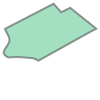

In [213]:
# get the first block group polygon in the data set
geo = philly_demo_final.iloc[0].geometry

geo

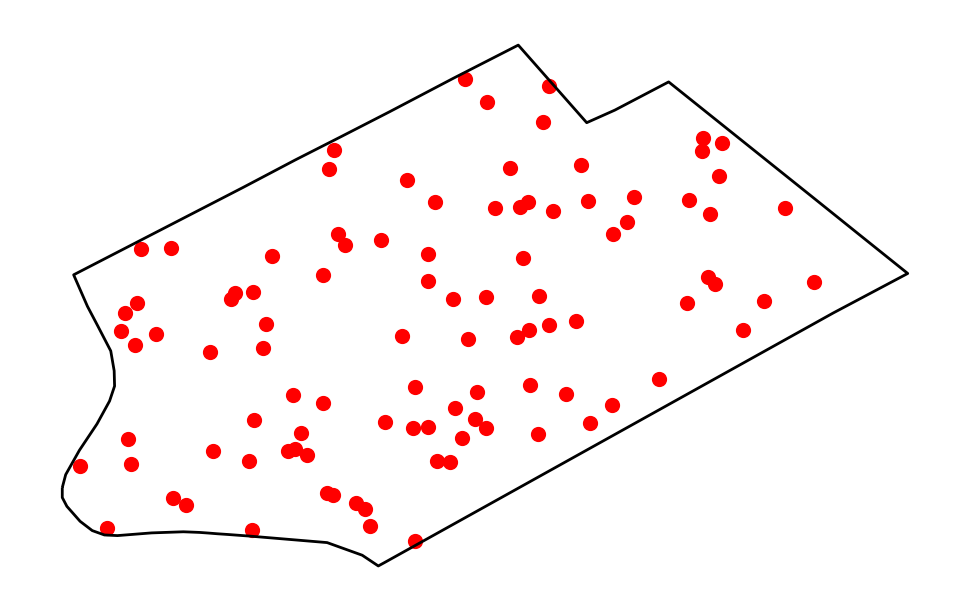

In [214]:
fig, ax = plt.subplots(figsize=(6, 6))

# Generate some random points
random_points = random_points_in_polygon(100, geo)

# Plot random points
gpd.GeoSeries(random_points).plot(ax=ax, markersize=20, color="red")

# Plot boundary of block group
gpd.GeoSeries([geo]).plot(ax=ax, facecolor="none", edgecolor="black")

ax.set_axis_off()

In [215]:
def generate_dot_map(data, people_per_dot):
    """
    Given a GeoDataFrame with demographic columns, generate a dot 
    map according to the population in each geometry.
    """
    results = []
    for field in ["White", "Hispanic", "Black", "Asian", "Other"]:

        # generate random points
        pts = data.apply(
            lambda row: random_points_in_polygon(
                row[field] / people_per_dot, row["geometry"]
            ),
            axis=1,
        )

        # combine into single GeoSeries
        pts = gpd.GeoSeries(pts.apply(pd.Series).stack(), dtype=object, crs=data["geometry"].crs)
        pts.name = "geometry"

        # make into a GeoDataFrame
        pts = gpd.GeoDataFrame(pts)
        pts["field"] = field

        # save
        results.append(pts)

    return gpd.GeoDataFrame(pd.concat(results), crs=data["geometry"].crs).reset_index(
        drop=True
    )

#### Calculate the dot map

In [216]:
dot_map = generate_dot_map(philly_demo_final, people_per_dot=50)

In [217]:
print("number of points = ", len(dot_map))

number of points =  34470


In [218]:
dot_map.tail()

geometry  field
34465  POINT (-75.23781 40.06410)  Other
34466  POINT (-75.23271 40.06475)  Other
34467  POINT (-75.07932 40.03467)  Other
34468  POINT (-75.08050 40.03537)  Other
34469  POINT (-75.08110 40.03554)  Other

#### Now let's plot it

In [219]:
# setup a custom color map from ColorBrewer
from matplotlib.colors import ListedColormap


colors = {
    "Black": "steelblue",
    "White": "tomato",
    "Hispanic": "khaki",
    "Asian": "palegreen",
    "Other": "darkgray",
}

cmap = ListedColormap([t[1] for t in sorted(colors.items())])

In [220]:
# Convert to 3857
dot_map_3857 = dot_map.to_crs(epsg=3857)

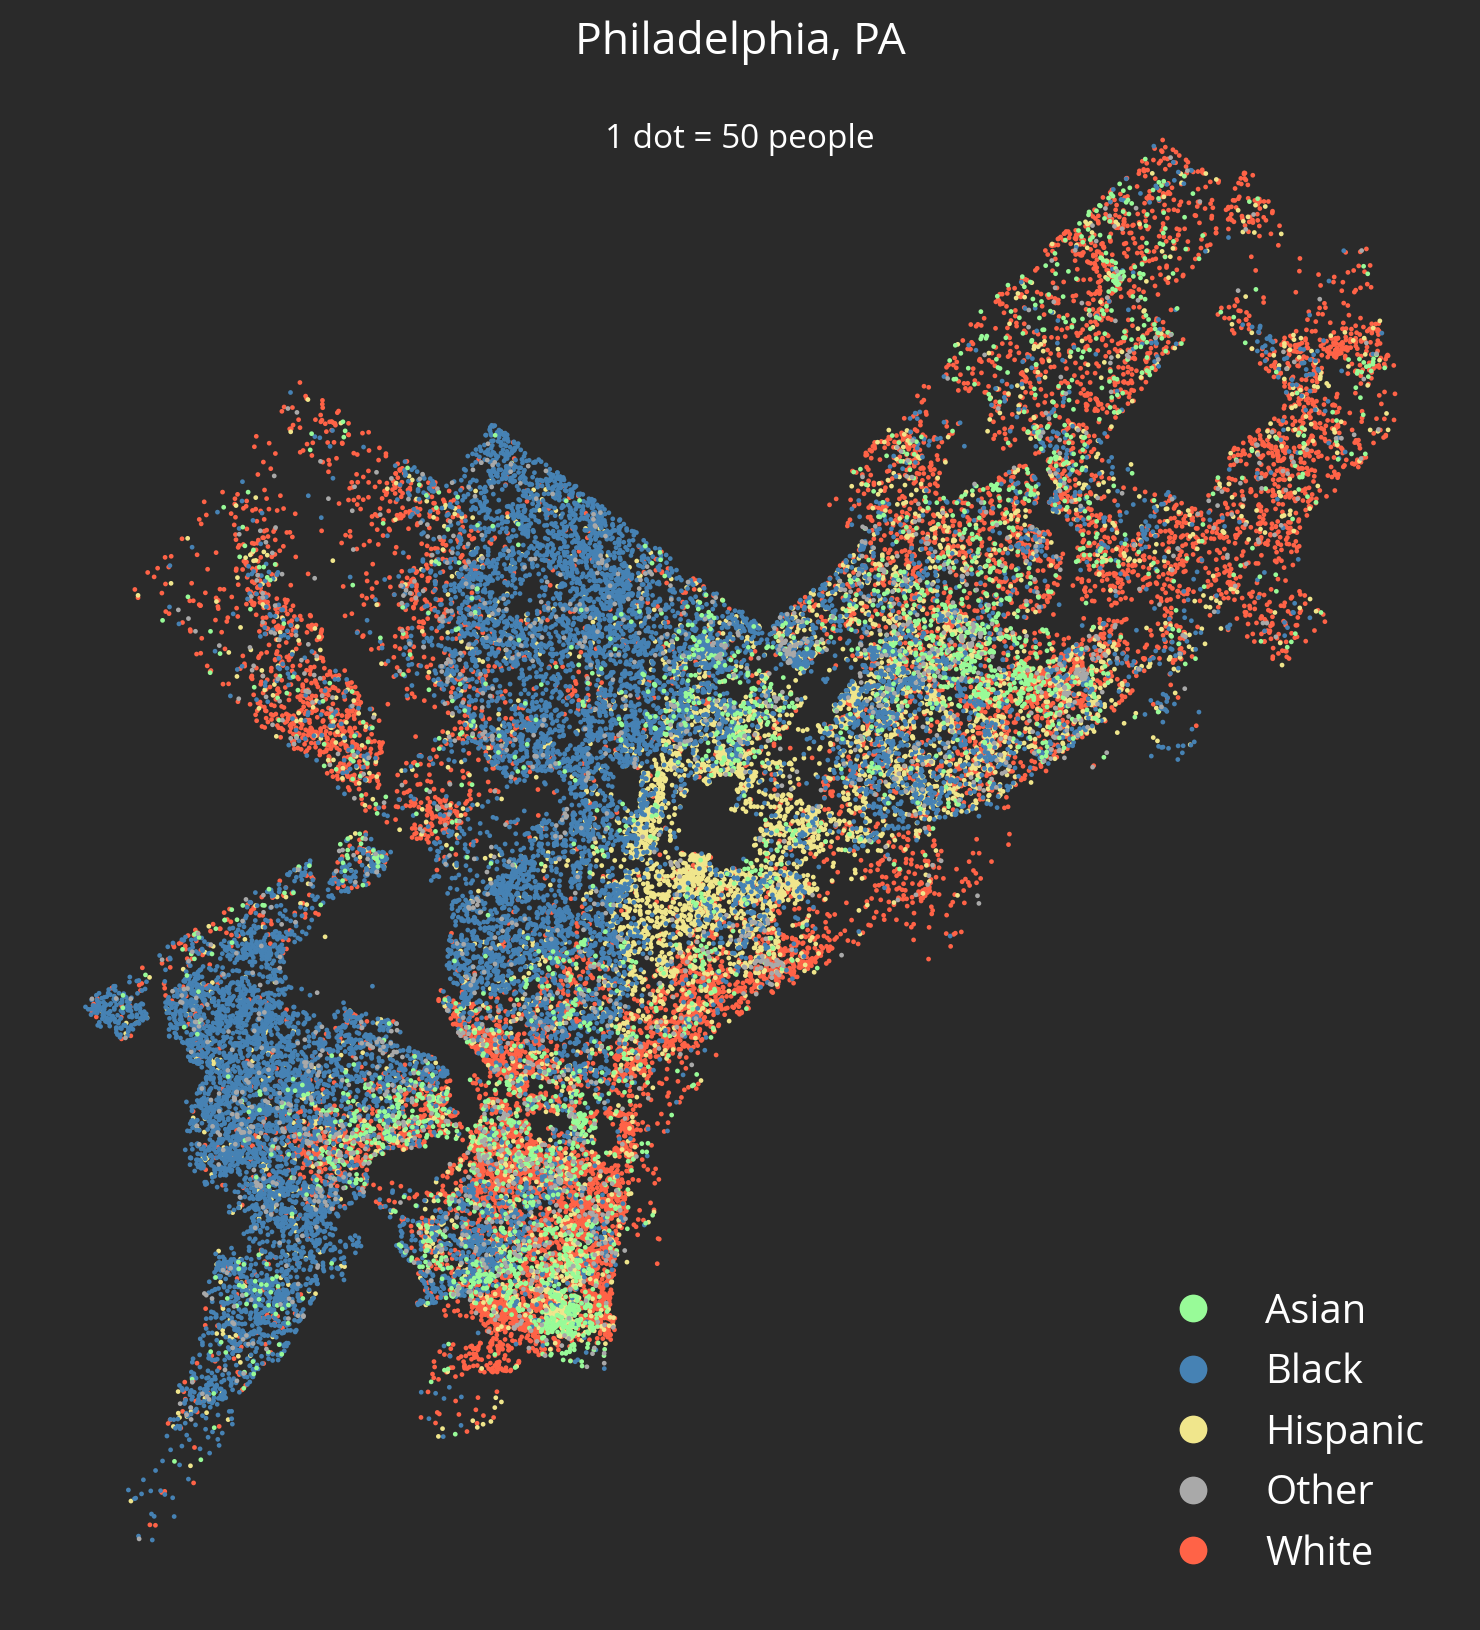

In [221]:
# Initialize the figure and axes
fig, ax = plt.subplots(figsize=(10, 10), facecolor="#2a2a2a")

# Plot
dot_map_3857.plot(
    ax=ax,
    column="field",
    categorical=True,
    legend=True,
    alpha=1,
    markersize=0.5,
    cmap=cmap,
    legend_kwds=dict(labelcolor="white"),
)

# format
ax.set_title("Philadelphia, PA", fontsize=16, color="white")
ax.text(
    0.5,
    0.95,
    "1 dot = 50 people",
    fontsize=12,
    transform=ax.transAxes,
    ha="center",
    color="white",
)
ax.set_axis_off()

## That's it!

- Next week: working with big (1M+ rows) datasets
- See you on Monday!